# Tick History Visualizer

Load `ticks.csv` and visualize odds fluctuations over time per market (moneyline, spreads, totals).


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

pd.set_option("display.max_columns", 100)

csv_path = Path("ticks.csv")
if not csv_path.exists():
    raise FileNotFoundError("ticks.csv not found. Run clean_output.py first to generate it.")

df = pd.read_csv(csv_path)

# Basic normalization
if "ts_iso" in df.columns:
    df["ts"] = pd.to_datetime(df["ts_iso"], errors="coerce")
elif "ts_epoch" in df.columns:
    df["ts"] = pd.to_datetime(df["ts_epoch"], unit="s", utc=True)
else:
    raise ValueError("ticks.csv missing ts_iso/ts_epoch columns")

# Ensure numeric price and compute implied probability in percent (cents)
df["price"] = pd.to_numeric(df.get("price"), errors="coerce")
df["price_pct"] = 100.0 / df["price"]

# Filter clearly malformed rows
df = df.dropna(subset=["ts", "price", "price_pct", "market"]).copy()

# Sort
df = df.sort_values(["event_id", "period_number", "market", "line", "side", "ts"]).reset_index(drop=True)

print("Rows:", len(df))
df.head()


Rows: 314


,event_id,sport_id,league_id,league_name,home,away,starts,period_number,period_description,market,line,side,ts_iso,ts_epoch,price,limit,ts,price_pct
0,1610679471,8,1624,UFC,Max Holloway,Dustin Poirier,2025-07-20T04:44:00,0,Fight,moneyline,NaN,away,2025-06-09T17:24:00+00:00,1749489840,1.877,950.0,2025-06-09 17:24:00+00:00,53.276505
1,1610679471,8,1624,UFC,Max Holloway,Dustin Poirier,2025-07-20T04:44:00,0,Fight,moneyline,NaN,away,2025-06-09T17:24:06+00:00,1749489846,1.892,950.0,2025-06-09 17:24:06+00:00,52.854123
2,1610679471,8,1624,UFC,Max Holloway,Dustin Poirier,2025-07-20T04:44:00,0,Fight,moneyline,NaN,away,2025-06-09T17:24:18+00:00,1749489858,1.909,950.0,2025-06-09 17:24:18+00:00,52.383447
3,1610679471,8,1624,UFC,Max Holloway,Dustin Poirier,2025-07-20T04:44:00,0,Fight,moneyline,NaN,away,2025-06-09T18:55:18+00:00,1749495318,1.934,950.0,2025-06-09 18:55:18+00:00,51.706308
4,1610679471,8,1624,UFC,Max Holloway,Dustin Poirier,2025-07-20T04:44:00,0,Fight,moneyline,NaN,away,2025-06-09T18:56:17+00:00,1749495377,1.952,950.0,2025-06-09 18:56:17+00:00,51.229508


In [33]:
# Choose event to visualize
# Lists a few most recent events; change filters as needed

# Derive a display label for grouping
name_cols = ["league_name", "home", "away", "starts"]
for c in name_cols:
    if c not in df.columns:
        df[c] = np.nan

latest = (df
    .groupby("event_id")
    .agg(starts=("starts", "first"), league_name=("league_name", "first"), home=("home", "first"), away=("away", "first"))
    .reset_index()
)

latest = latest.sort_values("starts").tail(10)
latest


,event_id,starts,league_name,home,away
0,1610679471,2025-07-20T04:44:00,UFC,Max Holloway,Dustin Poirier


In [34]:
# Pick one event_id from the table above
# You can hardcode it or set it dynamically. For now, auto-pick the most recent.

chosen_event = latest.tail(1)["event_id"].iloc[0]
print("Chosen event:", chosen_event)

df_e = df[df["event_id"] == chosen_event].copy()
print(df_e[["event_id", "league_name", "home", "away", "starts"]].drop_duplicates())


Chosen event: 1610679471
     event_id league_name          home            away               starts
0  1610679471         UFC  Max Holloway  Dustin Poirier  2025-07-20T04:44:00


In [35]:
# Diagnose and clean time series per market/line/side

df_e = df[df["event_id"] == chosen_event].copy()

# Focus on main game period by default
if "period_number" in df_e.columns:
    df_e = df_e[df_e["period_number"].fillna(0) == 0]

# Sort properly
cols_sort = ["market", "line", "side", "ts"]
df_e = df_e.sort_values(cols_sort).reset_index(drop=True)

# Detect non-monotonic timestamps and duplicate timestamps within each group
problems = []
for (m, ln, s), g in df_e.groupby(["market", "line", "side"], dropna=False):
    tt = g["ts"].values
    # any backward time steps
    if (pd.Series(tt).diff().dt.total_seconds().fillna(0) < 0).any():
        problems.append((m, ln, s, "non_monotonic_ts"))
    # duplicate timestamps
    if g["ts"].duplicated().any():
        problems.append((m, ln, s, "duplicate_ts"))

print("Problem groups:", problems[:10], "..." if len(problems) > 10 else "")

# Clean: within each (market,line,side), sort by ts, then keep last row per ts
parts = []
for key, g in df_e.groupby(["market", "line", "side"], dropna=False):
    gg = g.sort_values("ts").drop_duplicates(subset=["ts"], keep="last")
    parts.append(gg)

df_e_clean = pd.concat(parts, ignore_index=True).sort_values(["market", "line", "side", "ts"]).reset_index(drop=True)
print("Original rows:", len(df_e), "Clean rows:", len(df_e_clean))


Problem groups: [] 
Original rows: 314 Clean rows: 314


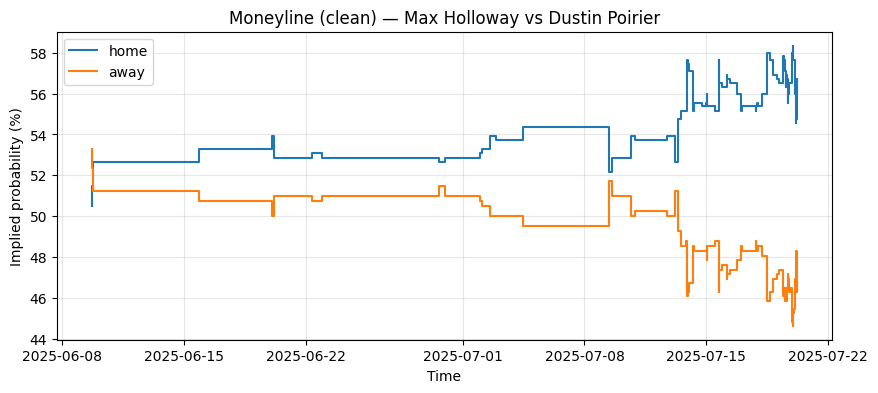

In [36]:
# Plot cleaned series (implied probability)

home_name = str(df_e_clean["home"].iloc[0]) if "home" in df_e_clean.columns and not df_e_clean.empty else "home"
away_name = str(df_e_clean["away"].iloc[0]) if "away" in df_e_clean.columns and not df_e_clean.empty else "away"

def plot_moneyline_clean(df_e):
    d = df_e[df_e["market"] == "moneyline"].copy()
    if d.empty:
        print("No moneyline data (clean)")
        return
    plt.figure(figsize=(10, 4))
    for side, color in [("home", "tab:blue"), ("away", "tab:orange"), ("draw", "tab:green")]:
        dd = d[d["side"] == side]
        if dd.empty:
            continue
        plt.step(dd["ts"], dd["price_pct"], where="post", label=side, color=color)
    plt.title(f"Moneyline (clean) — {home_name} vs {away_name}")
    plt.xlabel("Time")
    plt.ylabel("Implied probability (%)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_moneyline_clean(df_e_clean)


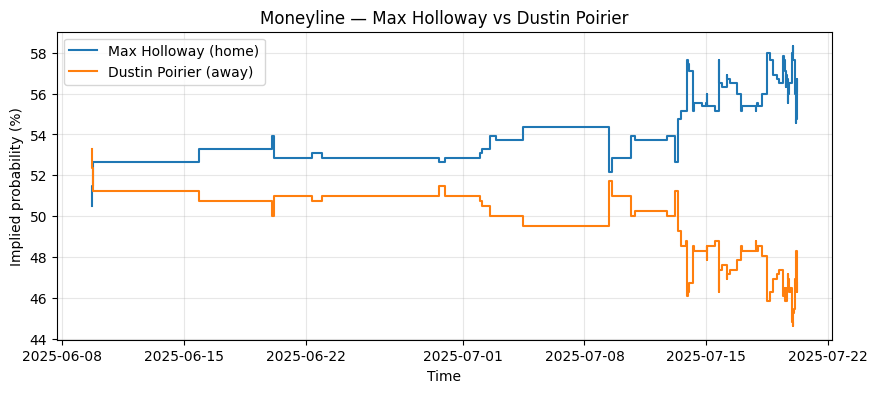

No spreads data


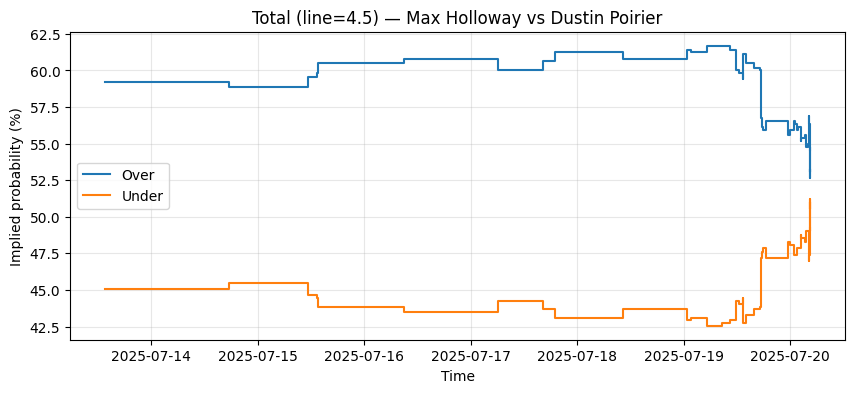

In [ ]:
# Override plots to include team names in labels

home_name = str(df_e["home"].iloc[0]) if "home" in df_e.columns and not df_e.empty else "home"
away_name = str(df_e["away"].iloc[0]) if "away" in df_e.columns and not df_e.empty else "away"


def plot_moneyline_named(df_e):
    d = df_e[df_e["market"] == "moneyline"].copy()
    if d.empty:
        print("No moneyline data")
        return
    plt.figure(figsize=(10, 4))
    legend_map = {
        "home": f"{home_name} (home)",
        "away": f"{away_name} (away)",
        "draw": "Draw",
    }
    for side, color in [("home", "tab:blue"), ("away", "tab:orange"), ("draw", "tab:green")]:
        dd = d[d["side"] == side]
        if dd.empty:
            continue
        plt.step(dd["ts"], dd["price_pct"], where="post", label=legend_map.get(side, side), color=color)
    plt.title(f"Moneyline — {home_name} vs {away_name}")
    plt.xlabel("Time")
    plt.ylabel("Implied probability (%)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


def plot_spreads_named(df_e):
    d = df_e[df_e["market"] == "spread"].copy()
    if d.empty:
        print("No spreads data")
        return
    for line, dd in d.groupby("line"):
        plt.figure(figsize=(10, 4))
        d_home = dd[dd["side"] == "home"]
        d_away = dd[dd["side"] == "away"]
        if not d_home.empty:
            plt.step(d_home["ts"], d_home["price_pct"], where="post", label=f"{home_name} (home)")
        if not d_away.empty:
            plt.step(d_away["ts"], d_away["price_pct"], where="post", label=f"{away_name} (away)")
        plt.title(f"Spread (line={line}) — {home_name} vs {away_name}")
        plt.xlabel("Time")
        plt.ylabel("Implied probability (%)")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()


def plot_totals_named(df_e):
    d = df_e[df_e["market"] == "total"].copy()
    if d.empty:
        print("No totals data")
        return
    for line, dd in d.groupby("line"):
        plt.figure(figsize=(10, 4))
        d_over = dd[dd["side"] == "over"]
        d_under = dd[dd["side"] == "under"]
        if not d_over.empty:
            plt.step(d_over["ts"], d_over["price_pct"], where="post", label="Over")
        if not d_under.empty:
            plt.step(d_under["ts"], d_under["price_pct"], where="post", label="Under")
        plt.title(f"Total (line={line}) — {home_name} vs {away_name}")
        plt.xlabel("Time")
        plt.ylabel("Implied probability (%)")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

plot_moneyline_named(df_e)
plot_spreads_named(df_e)
plot_totals_named(df_e)
